# Deep Learning from Udacity (Google)

## Assignment 2


Use notMNIST dataset to classify numbers with kdb, q and python 
<br>It is assumed that the dataset has been prepared in Assignment 1 and we seek to perform some tensor operations here
<br>
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/2_fullyconnected.ipynb

In [1]:
/Initialisation
\c 200 200
np:.p.import[`numpy];
tf:.p.import[`tensorflow];
keras:.p.import[`keras];
sns:.p.import[`seaborn];
pd:.p.import[`pandas];
plt:.p.import[`matplotlib;`:pyplot];

/home/limguanyu_08_gmail_com/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
/Switch to decide to run training model or load model from file
p)loadSaveFile=input("Input choice to load or train model (1b/0b): ")
loadSaveFile:value .p.get[`loadSaveFile]`;
$[loadSaveFile;-1"Loading save file from disk instead of training it";-1"Skipping load and train model"];

Input choice to load or train model (1b/0b): 1b
Loading save file from disk instead of training it


In [18]:
//Only need to run this to reload model
//This has to be ran at start if required
$[loadSaveFile;
    [-1"Loading deepLearningModel from disk";load_model:keras[`:models][`:load_model];
    res:load_model[`deepLearningModel.h5]];
    -1"Skipping load and train model"
 ];

Loading deepLearningModel from disk


### Load data into memory from hdb
Previously we have stored the data in DeepLearning/notMNIST_large/flatTable
Only run this notebook if Assignment 1 has been done

In [3]:
/show that the flat table exists
$[()~flats:key `:DeepLearning/notMNIST_large/flatTable;
    -2"ERROR: FlatTable are missing from previous assignments";
    [-1"INFO: FlatTable found, loading hdb into memory";
    system "l DeepLearning/notMNIST_large/flatTable";
    tables[]
    ]
 ]

INFO: FlatTable found, loading hdb into memory


`s#`largeTableA`largeTableB`largeTableC`largeTableD`largeTableE`largeTableF`largeTableG`largeTableH`largeTableI`largeTableJ


In [4]:
/peek at the data
raze ?[;enlist(<;`i;2);0b;()] each tables[]

alphabet imgData                                                                                                                                                                                     ..
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..
A        0  0   0   0   2   1   0   0   40  102 154 183 172 153 127 70  26  0   0   1   2   0   0   0   0   0   0   0   0   0   0   3   0   0   82  184 245 255 255 255 255 255 255 255 230 170 67  0..
A        0  0   0   0   0   0   0   0   0   0   1   0   2   180 106 0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   81  255 149 0   4   0   0   0..
B        0  34  147 143 26  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   37  227 255 255 206 10  1   1   0   0   0   0   0   0   0   0   0   0   0   0..


In [5]:
/
now we will construct the test, validation and training set
test:10000*10
validation:10000*10
train:30000*10
\

/generate 50000 unique random numbers
rndNumbers:-50000?50000
testIndex:-10000?rndNumbers;
validationIndex:-10000?rndNumbers:rndNumbers except testIndex;
trainIndex:rndNumbers except validationIndex;

-1"Forming of table...";
{x set raze ?[;enlist(in;`i;y);0b;()] each tables[]} .'((`validationTable;validationIndex);(`testTable;testIndex);(`trainTable;trainIndex))

Forming of table...


`validationTable`testTable`trainTable


Number of entries in each table 

validationTable| 100000
testTable      | 110000
trainTable     | 360000


Show that the imgData is now a list of 784 data points instead of 28x28
784


In [6]:
/show that tables have been created
-1"Number of entries in each table \n";
show `validationTable`testTable`trainTable!(count value @) each `validationTable`testTable`trainTable;
-1"\n";
/show the size of the imgGrid
-1"Show that the imgData is now a list of 784 data points instead of 28x28";
0N! count raze 1#trainTable`imgData;

In [7]:
/clear flat tables from memory since not using 
-1"Deleting flat tables from memory to free up space";
{![`.;();0b;enlist x]} each 1_flats

Deleting flat tables from memory to free up space


`.`.`.`.`.`.`.`.`.`.


### Create one hot encoding for labels
For tensorflow to work, we will need to one hot encode the labels into in a 1x10 matrix in 1 column (similar to imgdata)
<br>if A -> 1 0 0 0 0 0 0 0 0 0
<br>if B -> 0 1 0 0 0 0 0 0 0 0
<br>so on til J

In [8]:
{update labels:flip alphabet=/:`$'10#.Q.A from x} each `testTable`trainTable`validationTable

`testTable`trainTable`validationTable


In [9]:
/show the labels and alphabet to show that this was matched correctly
-10?select alphabet, labels from trainTable 

alphabet labels     
--------------------
B        0100000000b
B        0100000000b
H        0000000100b
B        0100000000b
H        0000000100b
A        1000000000b
F        0000010000b
F        0000010000b
C        0010000000b
E        0000100000b


## Normalisation of training data
There is a need to normalise the data as it is going from 0 to 255 but actually we can do with 0 to 1 and this will speed up the training with lower overheads

In [10]:
{update imgData%255 from x} each `testTable`trainTable`validationTable

`testTable`trainTable`validationTable


In [11]:
/show the labels and alphabet to show that this was matched correctly
-2?select alphabet, imgData from trainTable 

alphabet imgData                                                                                                                                                                                     ..
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..
E        0.6745098 1 0.9882353 1 1           1          1 1 1          1         1         1        1         1         1         1         1         1         1        1         1         1 1     ..
C        0         0 0         0 0.003921569 0.01176471 0 0 0.09019608 0.3607843 0.6117647 0.772549 0.8862745 0.9411765 0.9764706 0.9607843 0.9058824 0.8039216 0.654902 0.4196078 0.1372549 0 0.0117..


## Enlistment of data into numpy for Keras

In [12]:
-1"numpy enlistment of labels\n";
print npTrainLabel:np[`:array][trainTable`labels]
-1"numpy enlistment of training data\n";
print npTrainData:np[`:array][trainTable`imgData]

-1"Running numpy enlistment of all data\n";
npTestData:np[`:array][testTable`imgData]
npTestLabel:np[`:array][testTable`labels]

numpy enlistment of labels

[[ True False False ... False False False]
 [ True False False ... False False False]
 [ True False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
numpy enlistment of training data

[[0.99215686 0.99215686 0.99215686 ... 0.12156863 0.         0.00784314]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [1.         1.         1.         ... 0.98823529 1.         0.56862745]
 [1.         1.         1.         ... 0.99607843 1.         0.85882353]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Running numpy enlistment of all data



### Building tensor model
Due to the structure of tensorflow we will build our model using keras as an overlay
<br>This allows us to continue with embedpy syntax

In [13]:
/for building the model with keras we will import layers and the models
seq:keras[`:models][`:Sequential][];
Dense:keras[`:layers][`:Dense];
Conv1D:keras[`:layers][`:Convolution1D];
MaxPooling1D:keras[`:layers][`:MaxPooling1D];
Flatten:keras[`:layers][`:core][`:Flatten];
Dropout:keras[`:layers][`:core][`:Dropout];

//help Conv1D
//seq[`:add]Conv1D[64;3;`input_shape pykw (count) 28*28;`activation pykw `relu];
//seq[`:add]MaxPooling1D[`pool_length pykw 2];
//seq[`:add]Conv1D[32;3;`activation pykw `relu];
//seq[`:add]MaxPooling1D[`pool_length pykw 2];
//seq[`:add]Flatten[];
seq[`:add]Dense[512;`activation pykw `relu;`input_shape pykw enlist (28*28)];
seq[`:add]Dropout[0.5];
seq[`:add]Dense[256;`activation pykw `relu];
seq[`:add]Dense[10;`activation pykw `softmax];
seq[`:compile][`loss pykw `categorical_crossentropy;`optimizer pykw `sgd;`metrics pykw enlist`accuracy];
seq[`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


### Fit model
After building the neural network, we will try to train the model 

In [14]:
batch:128;
epochs:20;
start:.z.T;
$[not loadSaveFile;
    [compiledRes:seq[`:fit][npTrainData;npTrainLabel;pykwargs `batch_size`epochs`verbose!(batch;epochs;2)];
    -1"Training of model for ",string[epochs]," epochs took ",string .z.T-start];
    -1"Model was loaded hence training was skipped"
 ];

Model was loaded hence training was skipped


In [15]:
/due to the duration to train the model, it is advisable to save the model
/To save model, Creates a HDF5 file for the model

$[not loadSaveFile;
    [-1"Saving model to root";
    system "cd ../../..";
    print seq[`:save][`deepLearningModel.h5]];
    -1"No model was saved"
 ];

No model was saved


## Making predictions with trained model
`testTable`trainTable`validationTable are the tables we can use to test against

In [19]:
prediction:(first idesc@)each res[`:predict][npTestData]`;

In [49]:
class:where each testTable`labels
10?res:update Hit:raze Class=Prediction from([]Class:class;Prediction:prediction);
classToAlphabet:til[10]!`$'10#.Q.A
update classToAlphabet[Class],classToAlphabet[Prediction] from `res;
show 10?res

Class Prediction Hit
--------------------
G     G          1  
H     H          1  
I     I          1  
D     D          1  
E     E          1  
F     F          1  
F     F          1  
B     B          1  
I     D          0  
I     J          0  


`res


In [21]:
-1"Total Correct predictions\n";
exec hitRate:sum[Hit]%count[Hit] from res

Total Correct predictions



hitRate| 0.8988909


## Prediction analysis
From the predidction we are able to perform an analysis of the trained model. 
<br>This is in the following:
- Predcition accuracy per class
- Confusion Matrix of classification
- Would the confusion occur to human being too ?

In [50]:
-1 "Prediction accuracy per class";
select sum[Hit]%count[Hit] by Class from res

Prediction accuracy per class


Class| Hit      
-----| ---------
A    | 0.9161932
B    | 0.908341 
C    | 0.900507 
D    | 0.9194154
E    | 0.8995426
F    | 0.9066   
G    | 0.8728   
H    | 0.8966   
I    | 0.8645   
J    | 0.8946   


Analysis of Confusion Matrix for Classification



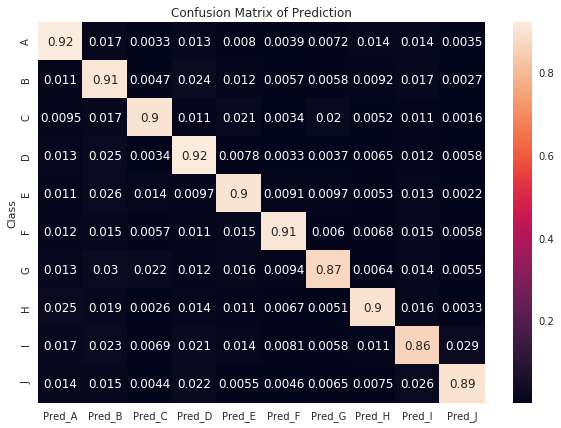

In [51]:
-1 "Analysis of Confusion Matrix for Classification\n";
ctab:update pcnt:num%sum num by Class from select num:count i by Class,Prediction from res
ctab:0!update p:{`$"Pred_",string x}each Prediction from ctab
cpivot:exec(p!pcnt)by Class:raze Class from ctab

sns[`:set][];
data:pd[`:DataFrame]cpivot;
data:data[`:set_index]keys cpivot;
plt[`:figure][`figsize pykw (10 7)];
sns[`:heatmap][data;`annot pykw 1b;`annot_kws pykw enlist[`size]!enlist 12];
plt[`:title]["Confusion Matrix of Prediction"];
plt[`:show][];

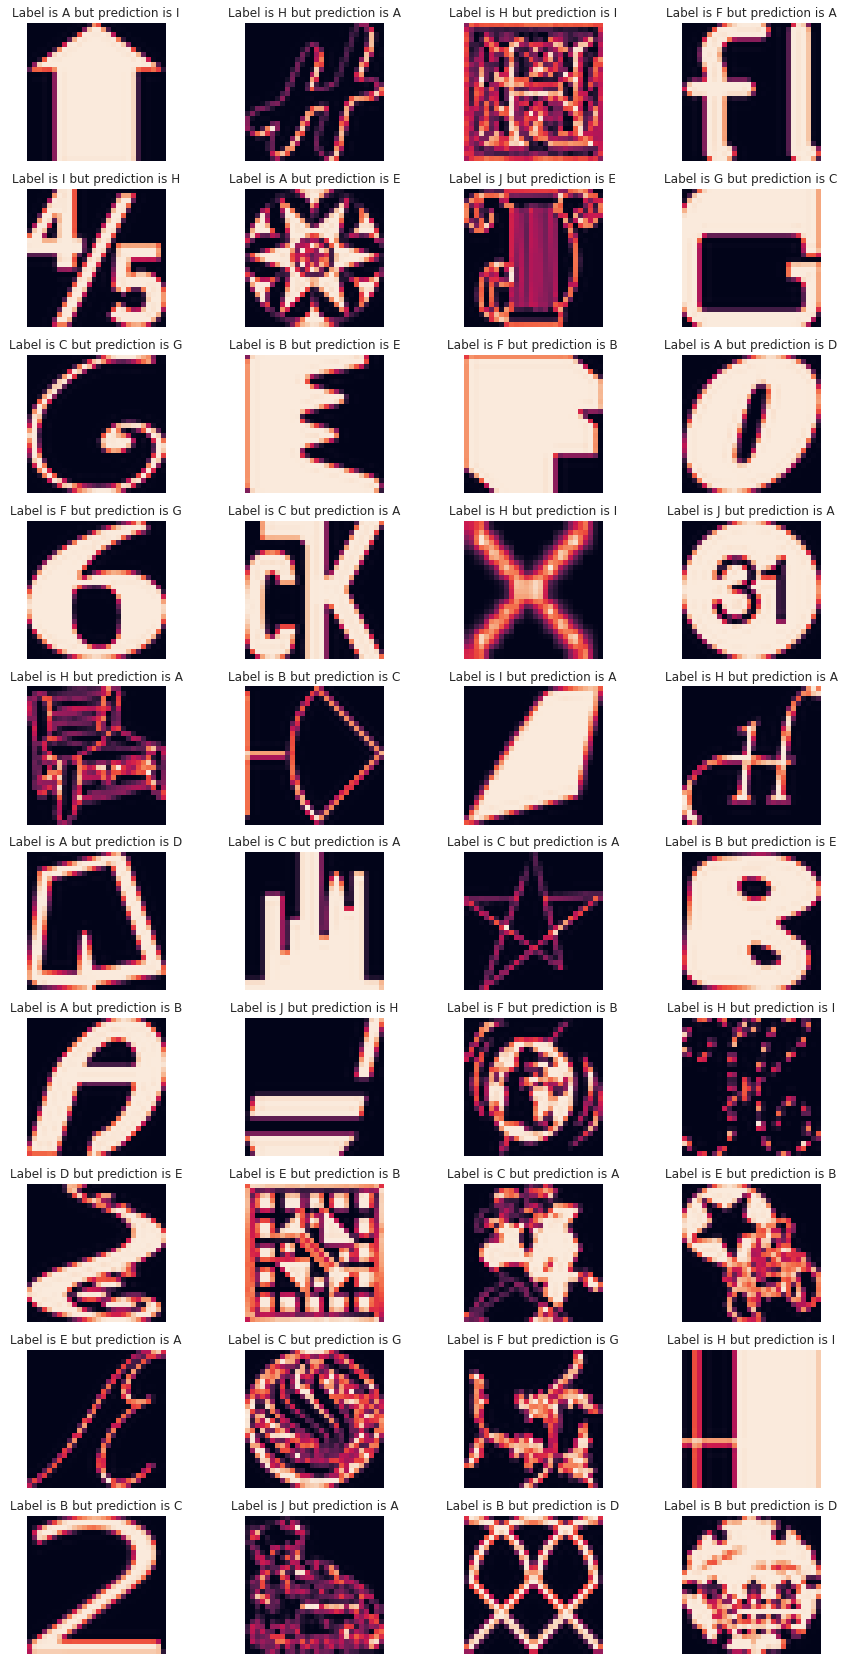

In [52]:
listOfMisses:exec i from res where Hit <> 1
indexPos:til[40]!40?listOfMisses

subplots:plt[`:subplots][10;4];
fig:subplots[@;0];
axarr:subplots[@;1];
fig[`:set_size_inches;15;30];

{position:cross[til 10;til 4];
    /Get into subplot array
    box:axarr[`$":__getitem__"].p.eval","sv string position x;
    
    box[`:imshow]"f"$28 cut testTable[`imgData]indexPos[x];
    box[`:axis]`off;
    box[`:set_title]"Label is ",(string first res[`Class] indexPos[x])," but prediction is ",string res[`Prediction] indexPos[x];
 }each til 40;

plt[`:show][];


## Ending Notes
From the output above, there are fair reasons to believe that the neural network was valuated on poor data. 
1. Some of the data are purely image and does not have a proper form even to humans hence if we remove the poor data, we might be able to have a much higher validated accuracy
2. There are times where the model was confused and this might have been contributed to distortion not being implemented in all images
3. We can improve the model by providing more dataset but introducing fat and skew distortion for training
4. Given that this does not use Convolution layer, there is a limitation to the model